# Symptom-Disease Prediction Model

This notebook demonstrates the development of a multi-output deep learning model for predicting diseases based on symptoms. The model also predicts related information such as disease severity, precautions, and descriptions.

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set plot style
sns.set_style('whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Data Loading and Exploration

Let's load and explore the symptom-disease datasets. We have four datasets to work with:
1. [dataset.csv](cci:7://file:///c:/Users/Sayan/Desktop/MedX/backend/datasets/symptoms/dataset.csv:0:0-0:0) - Contains diseases and their associated symptoms
2. [Symptom-severity.csv](cci:7://file:///c:/Users/Sayan/Desktop/MedX/backend/datasets/symptoms/Symptom-severity.csv:0:0-0:0) - Contains severity weights for each symptom
3. [symptom_Description.csv](cci:7://file:///c:/Users/Sayan/Desktop/MedX/backend/datasets/symptoms/symptom_Description.csv:0:0-0:0) - Contains descriptions for each disease
4. [symptom_precaution.csv](cci:7://file:///c:/Users/Sayan/Desktop/MedX/backend/datasets/symptoms/symptom_precaution.csv:0:0-0:0) - Contains precautions for each disease

In [2]:
# Define dataset paths
base_path = os.path.join('..', 'datasets', 'symptoms')
dataset_path = os.path.join(base_path, 'dataset.csv')
severity_path = os.path.join(base_path, 'Symptom-severity.csv')
description_path = os.path.join(base_path, 'symptom_Description.csv')
precaution_path = os.path.join(base_path, 'symptom_precaution.csv')

# Load the datasets
try:
    df_symptoms = pd.read_csv(dataset_path)
    df_severity = pd.read_csv(severity_path)
    df_description = pd.read_csv(description_path)
    df_precaution = pd.read_csv(precaution_path)
    print("All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading a dataset: {e}. Please make sure all four CSV files are uploaded correctly.")

# Display the first few rows of each dataset
print("\nSymptom-Disease Dataset:")
display(df_symptoms.head())

print("\nSymptom Severity Dataset:")
display(df_severity.head())

print("\nDisease Description Dataset:")
display(df_description.head())

print("\nDisease Precaution Dataset:")
display(df_precaution.head())

All datasets loaded successfully.

Symptom-Disease Dataset:


,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Symptom Severity Dataset:


,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5



Disease Description Dataset:


,Disease,Description
0,Drug Reaction,An adverse drug reaction (ADR) is an injury ca...
1,Malaria,An infectious disease caused by protozoan para...
2,Allergy,An allergy is an immune system response to a f...
3,Hypothyroidism,"Hypothyroidism, also called underactive thyroi..."
4,Psoriasis,Psoriasis is a common skin disorder that forms...



Disease Precaution Dataset:


,Disease,Precaution_1,Precaution_2,Precaution_3,Precaution_4
0,Drug Reaction,stop irritation,consult nearest hospital,stop taking drug,follow up
1,Malaria,Consult nearest hospital,avoid oily food,avoid non veg food,keep mosquitos out
2,Allergy,apply calamine,cover area with bandage,NaN,use ice to compress itching
3,Hypothyroidism,reduce stress,exercise,eat healthy,get proper sleep
4,Psoriasis,wash hands with warm soapy water,stop bleeding using pressure,consult doctor,salt baths



Symptom-Disease Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB
None

Number

Disease
Fungal infection       120
Allergy                120
GERD                   120
Chronic cholestasis    120
Drug Reaction          120
Peptic ulcer diseae    120
AIDS                   120
Diabetes               120
Gastroenteritis        120
Bronchial Asthma       120
Name: count, dtype: int64


Missing values in Symptom-Disease Dataset:


Disease          0
Symptom_1        0
Symptom_2        0
Symptom_3        0
Symptom_4      348
Symptom_5     1206
Symptom_6     1986
Symptom_7     2652
Symptom_8     2976
Symptom_9     3228
Symptom_10    3408
Symptom_11    3726
Symptom_12    4176
Symptom_13    4416
Symptom_14    4614
Symptom_15    4680
Symptom_16    4728
Symptom_17    4848
dtype: int64

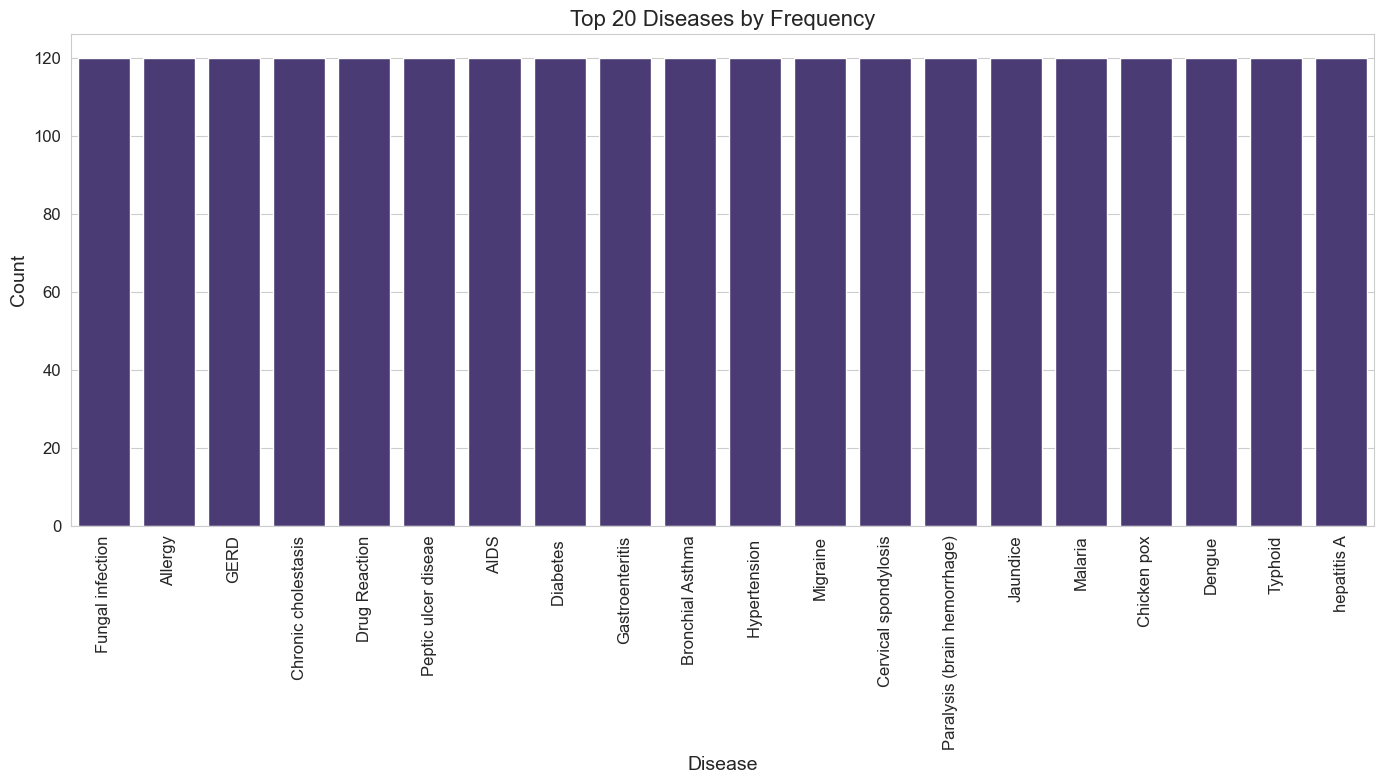

In [3]:
# Explore the datasets
print("\nSymptom-Disease Dataset Information:")
print(df_symptoms.info())

print("\nNumber of unique diseases:", df_symptoms['Disease'].nunique())
print("\nTop 10 diseases by frequency:")
display(df_symptoms['Disease'].value_counts().head(10))

# Check for missing values
print("\nMissing values in Symptom-Disease Dataset:")
display(df_symptoms.isnull().sum())

# Visualize disease distribution
plt.figure(figsize=(14, 8))
disease_counts = df_symptoms['Disease'].value_counts().head(20)
sns.barplot(x=disease_counts.index, y=disease_counts.values)
plt.title('Top 20 Diseases by Frequency', fontsize=16)
plt.xlabel('Disease', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Total unique symptoms: 131

Top 20 symptoms by frequency:


 fatigue              1932
 vomiting             1914
 high_fever           1362
 loss_of_appetite     1152
 nausea               1146
 headache             1134
 abdominal_pain       1032
 yellowish_skin        912
 yellowing_of_eyes     816
 chills                798
 skin_rash             786
 malaise               702
 chest_pain            696
 joint_pain            684
itching                678
 sweating              678
 dark_urine            570
 diarrhoea             564
 cough                 564
 irritability          474
Name: count, dtype: int64

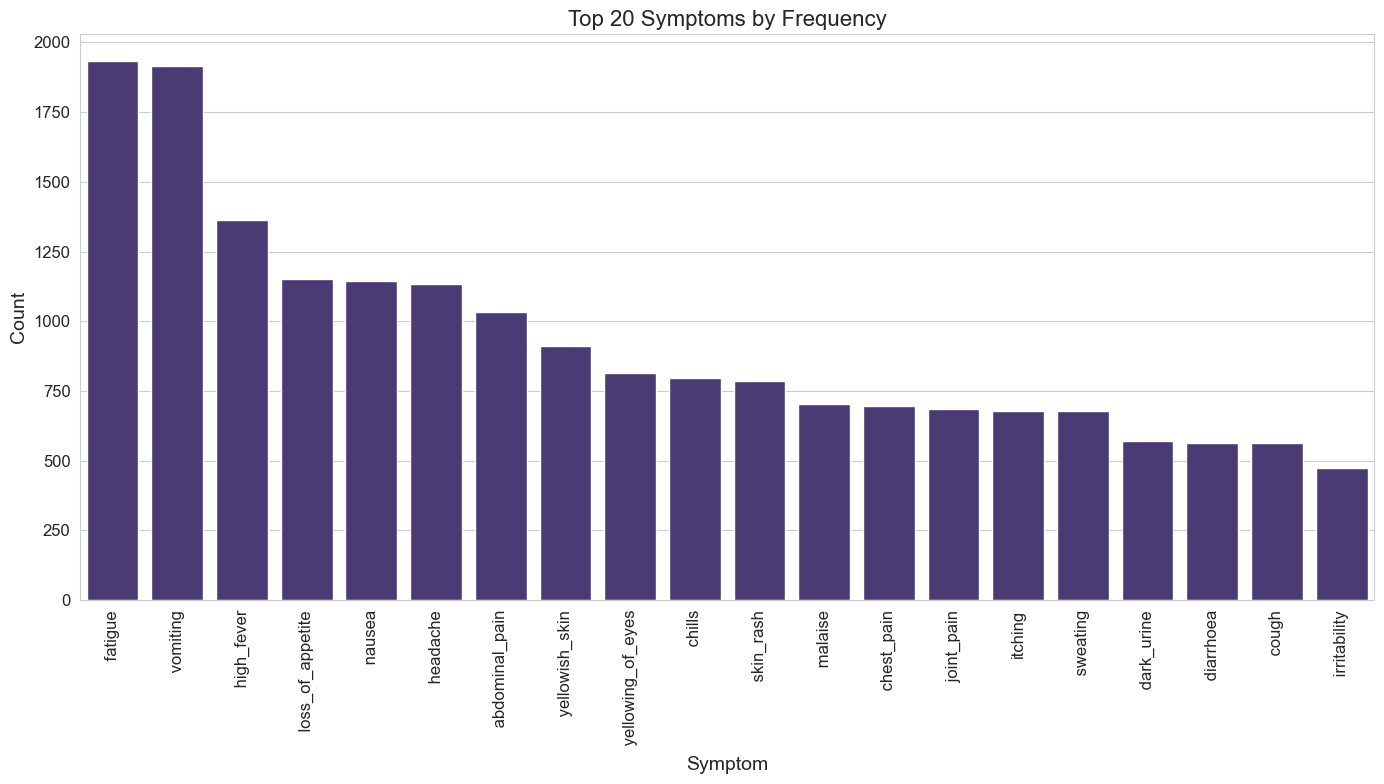

In [4]:
# Explore symptom distribution
symptom_columns = [col for col in df_symptoms.columns if 'Symptom' in col]

# Fill missing values with 'None'
df_symptoms[symptom_columns] = df_symptoms[symptom_columns].fillna('None')

# Count occurrences of each symptom
all_symptoms = []
for col in symptom_columns:
    all_symptoms.extend(df_symptoms[col].tolist())

# Remove 'None' values
all_symptoms = [s for s in all_symptoms if s != 'None']

# Count and display top symptoms
symptom_counts = pd.Series(all_symptoms).value_counts()
print(f"Total unique symptoms: {len(symptom_counts)}")
print("\nTop 20 symptoms by frequency:")
display(symptom_counts.head(20))

# Visualize top symptoms
plt.figure(figsize=(14, 8))
sns.barplot(x=symptom_counts.head(20).index, y=symptom_counts.head(20).values)
plt.title('Top 20 Symptoms by Frequency', fontsize=16)
plt.xlabel('Symptom', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Symptom Severity Distribution:


weight
1     1
2    15
3    21
4    39
5    35
6    17
7     5
Name: count, dtype: int64

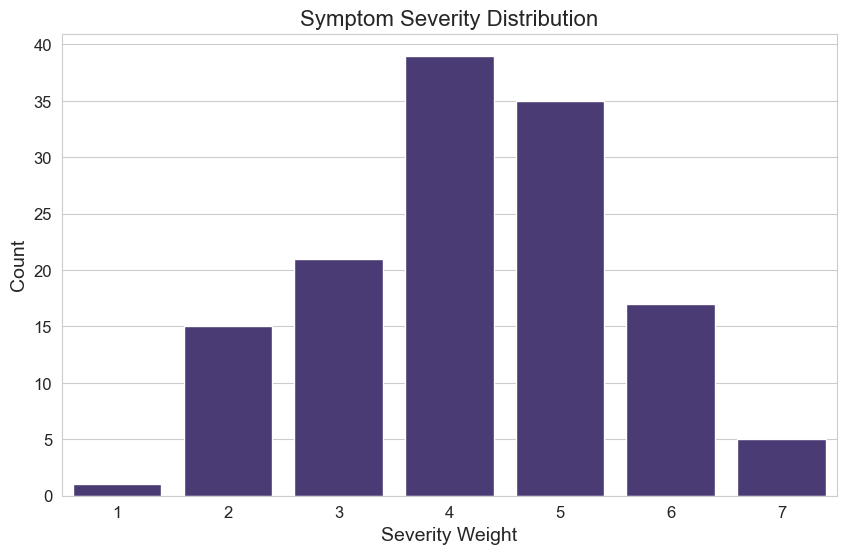


Top 5 symptoms with severity weight 1:


,Symptom,weight
0,itching,1



Top 5 symptoms with severity weight 2:


,Symptom,weight
21,lethargy,2
79,hip_joint_pain,2
80,muscle_weakness,2
96,irritability,2
97,muscle_pain,2



Top 5 symptoms with severity weight 3:


,Symptom,weight
1,skin_rash,3
5,chills,3
6,joint_pain,3
8,acidity,3
10,muscle_wasting,3



Top 5 symptoms with severity weight 4:


,Symptom,weight
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
9,ulcers_on_tongue,4
14,fatigue,4
16,anxiety,4



Top 5 symptoms with severity weight 5:


,Symptom,weight
4,shivering,5
7,stomach_pain,5
11,vomiting,5
17,cold_hands_and_feets,5
20,restlessness,5



Top 5 symptoms with severity weight 6:


,Symptom,weight
12,burning_micturition,6
13,spotting_urination,6
22,patches_in_throat,6
40,diarrhoea,6
44,acute_liver_failure,6



Top 5 symptoms with severity weight 7:


,Symptom,weight
25,high_fever,7
46,swelling_of_stomach,7
56,chest_pain,7
57,weakness_in_limbs,7
113,coma,7


In [5]:
# Explore symptom severity
print("\nSymptom Severity Distribution:")
display(df_severity['weight'].value_counts().sort_index())

# Visualize symptom severity distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='weight', data=df_severity)
plt.title('Symptom Severity Distribution', fontsize=16)
plt.xlabel('Severity Weight', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

# Show top symptoms for each severity level
for weight in sorted(df_severity['weight'].unique()):
    print(f"\nTop 5 symptoms with severity weight {weight}:")
    display(df_severity[df_severity['weight'] == weight].head(5))

Number of diseases with descriptions: 41
Average description length: 251.39 characters


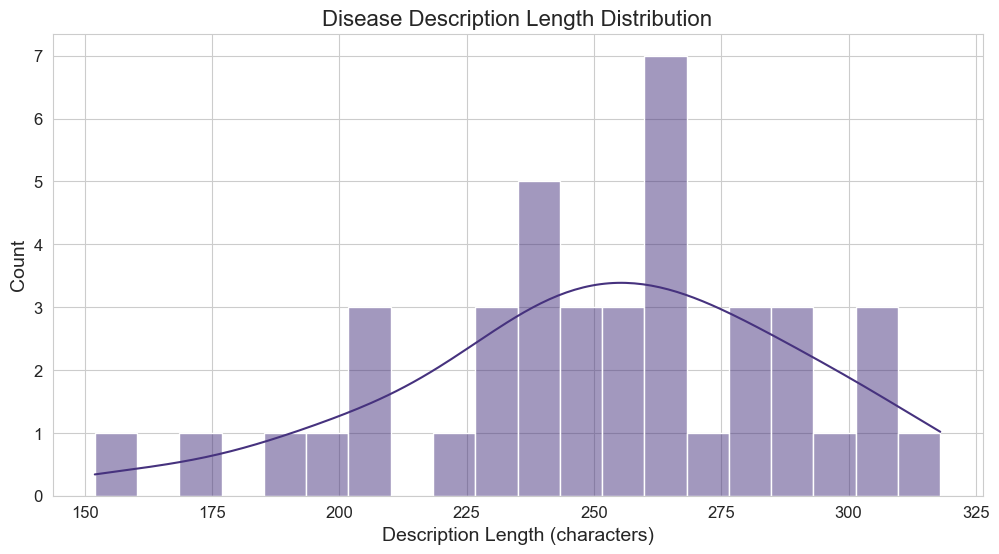


Number of diseases with precautions: 41

Precaution count distribution:


precaution_count
3     2
4    39
Name: count, dtype: int64

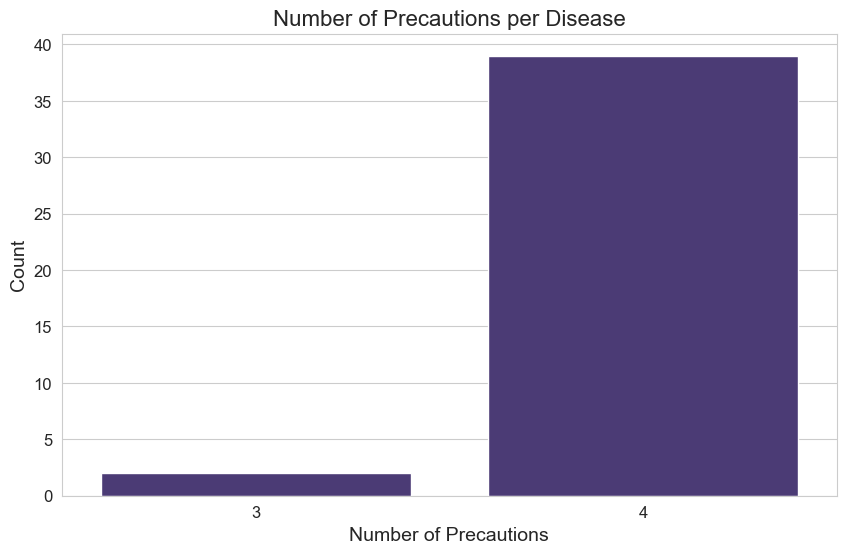

In [6]:
# Explore disease descriptions
print(f"Number of diseases with descriptions: {len(df_description)}")
print(f"Average description length: {df_description['Description'].str.len().mean():.2f} characters")

# Visualize description length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_description['Description'].str.len(), bins=20, kde=True)
plt.title('Disease Description Length Distribution', fontsize=16)
plt.xlabel('Description Length (characters)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

# Explore disease precautions
precaution_columns = [col for col in df_precaution.columns if 'Precaution' in col]
print(f"\nNumber of diseases with precautions: {len(df_precaution)}")

# Count non-null precautions per disease
df_precaution['precaution_count'] = df_precaution[precaution_columns].notna().sum(axis=1)
print("\nPrecaution count distribution:")
display(df_precaution['precaution_count'].value_counts().sort_index())

# Visualize precaution count distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='precaution_count', data=df_precaution)
plt.title('Number of Precautions per Disease', fontsize=16)
plt.xlabel('Number of Precautions', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

## 2. Data Preprocessing

Let's preprocess the symptom-disease datasets for model training.

Total unique symptoms: 131

One-hot encoded symptoms (first 5 rows, first 10 columns):


,indigestion,blurred_and_distorted_vision,continuous_feel_of_urine,sunken_eyes,stiff_neck,prominent_veins_on_calf,painful_walking,dehydration,spotting_ urination,skin_peeling
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0



Severity Category Distribution:


severity_category
Very Severe    2376
Severe         1800
Moderate        402
Mild            102
Very Mild         0
Name: count, dtype: int64

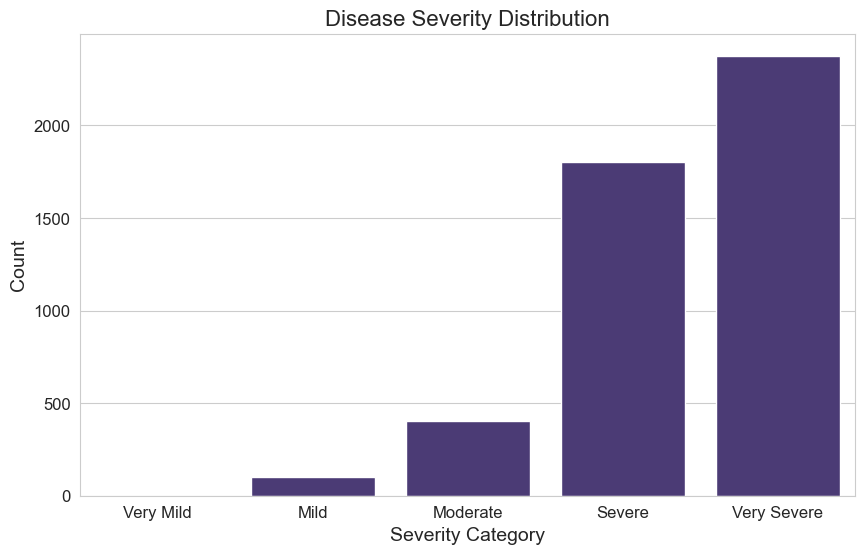

In [7]:
# Convert the symptom columns into a single list of symptoms for each row
df_symptoms['symptom_list'] = df_symptoms[symptom_columns].values.tolist()

# Create a set of all unique symptoms across the entire dataset
unique_symptoms = set()
for symptom_list in df_symptoms['symptom_list']:
    for symptom in symptom_list:
        if symptom != 'None':
            unique_symptoms.add(symptom.strip())

print(f"Total unique symptoms: {len(unique_symptoms)}")

# Create a severity mapping dictionary
symptom_severity_map = dict(zip(df_severity['Symptom'], df_severity['weight']))

# Implement one-hot encoding on the symptom list
def one_hot_encode_symptoms(symptom_list, unique_symptoms):
    encoding = {}
    for symptom in unique_symptoms:
        encoding[symptom] = 1 if symptom in [s.strip() for s in symptom_list if s != 'None'] else 0
    return encoding

# Apply the one-hot encoding function
symptom_encoding = df_symptoms['symptom_list'].apply(lambda x: one_hot_encode_symptoms(x, unique_symptoms))

# Convert the dictionary to a DataFrame
df_encoded = pd.DataFrame(list(symptom_encoding))

# Display the first few rows of the encoded DataFrame
print("\nOne-hot encoded symptoms (first 5 rows, first 10 columns):")
display(df_encoded.iloc[:5, :10])

# Calculate severity for each row based on symptoms
def calculate_row_severity(row, symptom_severity_map):
    severity = 0
    symptom_count = 0
    for symptom, present in row.items():
        if present == 1:
            severity += symptom_severity_map.get(symptom, 0)  # Default to 0 if symptom not found
            symptom_count += 1
    return 0 if symptom_count == 0 else severity / symptom_count

# Calculate average severity for each row
df_encoded['severity'] = df_encoded.apply(lambda row: calculate_row_severity(row, symptom_severity_map), axis=1)

# Bin severity into categories
df_encoded['severity_category'] = pd.cut(
    df_encoded['severity'],
    bins=[0, 1, 2, 3, 4, 5],
    labels=['Very Mild', 'Mild', 'Moderate', 'Severe', 'Very Severe']
)

# Display severity distribution
print("\nSeverity Category Distribution:")
display(df_encoded['severity_category'].value_counts())

# Visualize severity distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='severity_category', data=df_encoded, order=['Very Mild', 'Mild', 'Moderate', 'Severe', 'Very Severe'])
plt.title('Disease Severity Distribution', fontsize=16)
plt.xlabel('Severity Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [8]:
# Merge disease information with descriptions and precautions
df_merged = pd.merge(df_symptoms[['Disease']], df_description, on='Disease', how='left')
df_merged = pd.merge(df_merged, df_precaution, on='Disease', how='left')

# Fill missing descriptions and precautions
df_merged['Description'] = df_merged['Description'].fillna('No description available')
precaution_columns = [col for col in df_merged.columns if 'Precaution' in col]
df_merged[precaution_columns] = df_merged[precaution_columns].fillna('None')

# Combine precautions into a single string
df_merged['Precautions'] = df_merged[precaution_columns].apply(
    lambda row: ', '.join([p for p in row if p != 'None']), axis=1
)

# Display the merged dataset
print("\nMerged Disease Information:")
display(df_merged[['Disease', 'Description', 'Precautions']].head())

# Add disease and other target columns to the encoded DataFrame
df_encoded['Disease'] = df_symptoms['Disease'].values
df_encoded = pd.merge(df_encoded, df_merged[['Disease', 'Description', 'Precautions']], on='Disease', how='left')

# Display the final preprocessed dataset
print("\nFinal Preprocessed Dataset (sample columns):")
display(df_encoded[['Disease', 'severity', 'severity_category', 'Description', 'Precautions']].head())


Merged Disease Information:


,Disease,Description,Precautions
0,Fungal infection,"In humans, fungal infections occur when an inv...","bath twice, use detol or neem in bathing water..."
1,Fungal infection,"In humans, fungal infections occur when an inv...","bath twice, use detol or neem in bathing water..."
2,Fungal infection,"In humans, fungal infections occur when an inv...","bath twice, use detol or neem in bathing water..."
3,Fungal infection,"In humans, fungal infections occur when an inv...","bath twice, use detol or neem in bathing water..."
4,Fungal infection,"In humans, fungal infections occur when an inv...","bath twice, use detol or neem in bathing water..."



Final Preprocessed Dataset (sample columns):


,Disease,severity,severity_category,Description,Precautions
0,Fungal infection,2.0,Mild,"In humans, fungal infections occur when an inv...","bath twice, use detol or neem in bathing water..."
1,Fungal infection,2.0,Mild,"In humans, fungal infections occur when an inv...","bath twice, use detol or neem in bathing water..."
2,Fungal infection,2.0,Mild,"In humans, fungal infections occur when an inv...","bath twice, use detol or neem in bathing water..."
3,Fungal infection,2.0,Mild,"In humans, fungal infections occur when an inv...","bath twice, use detol or neem in bathing water..."
4,Fungal infection,2.0,Mild,"In humans, fungal infections occur when an inv...","bath twice, use detol or neem in bathing water..."


## 3. Prepare Data for Model Training

Let's prepare the data for training the multi-output deep learning model.

In [10]:
# Encode categorical target variables
label_encoders = {}
target_columns = ['Disease', 'Description', 'Precautions', 'severity_category']

for column in target_columns:
    le = LabelEncoder()
    df_encoded[f'{column}_encoded'] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le
    
    # Print encoding information
    print(f"\n{column} Encoding:")
    for i, class_name in enumerate(le.classes_):
        print(f"  {i}: {str(class_name)[:50]}{'...' if len(str(class_name)) > 50 else ''}")
        if i >= 4 and len(le.classes_) > 10:  # Show only first 5 for large encodings
            print(f"  ... ({len(le.classes_) - 5} more classes)")
            break

# Prepare feature matrix (X) and target vectors (y)
# Remove non-feature columns
feature_columns = [col for col in df_encoded.columns if col not in 
                   ['Disease', 'Description', 'Precautions', 'severity', 'severity_category'] + 
                   [f'{col}_encoded' for col in target_columns]]

X = df_encoded[feature_columns].values
y_disease = df_encoded['Disease_encoded'].values
y_description = df_encoded['Description_encoded'].values
y_precautions = df_encoded['Precautions_encoded'].values
y_severity = df_encoded['severity_category_encoded'].values

# Convert to categorical format
y_disease_cat = to_categorical(y_disease)
y_description_cat = to_categorical(y_description)
y_precautions_cat = to_categorical(y_precautions)
y_severity_cat = to_categorical(y_severity)

# Print shapes
print(f"\nFeature matrix shape: {X.shape}")
print(f"Disease target shape: {y_disease_cat.shape}")
print(f"Description target shape: {y_description_cat.shape}")
print(f"Precautions target shape: {y_precautions_cat.shape}")
print(f"Severity target shape: {y_severity_cat.shape}")

# Split data into training and testing sets
X_train, X_test, y_disease_train, y_disease_test, y_description_train, y_description_test, \
y_precautions_train, y_precautions_test, y_severity_train, y_severity_test = train_test_split(
    X, y_disease_cat, y_description_cat, y_precautions_cat, y_severity_cat, 
    test_size=0.2, random_state=42, stratify=y_disease
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Disease Encoding:
  0: (vertigo) Paroymsal  Positional Vertigo
  1: AIDS
  2: Acne
  3: Alcoholic hepatitis
  4: Allergy
  ... (36 more classes)

Description Encoding:
  0:  Hypoglycemia is a condition in which your blood s...
  1: A migraine can cause severe throbbing pain or a pu...
  2: A rare form of liver inflammation caused by infect...
  3: A vein that has enlarged and twisted, often appear...
  4: Acne vulgaris is the formation of comedones, papul...
  ... (34 more classes)

Precautions Encoding:
  0: Consult nearest hospital, avoid oily food, avoid n...
  1: Consult nearest hospital, vaccination, eat healthy...
  2: Consult nearest hospital, wash hands through, avoi...
  3: acetaminophen, consult nearest hospital, follow up...
  4: apply calamine, cover area with bandage, use ice t...
  ... (36 more classes)

severity_category Encoding:
  0: Mild
  1: Moderate
  2: Severe
  3: Very Severe
  4: nan

Feature matrix shape: (590400, 131)
Disease target shape: (590400, 41)
Descrip

## 4. Build Multi-Output Deep Learning Model

Let's build a multi-output deep learning model that predicts disease, description, precautions, and severity.

In [11]:
# Define the multi-output model architecture
def create_multi_output_model(input_dim, disease_classes, description_classes, precaution_classes, severity_classes):
    # Input layer
    inputs = Input(shape=(input_dim,), name='symptom_input')
    
    # Shared layers
    x = Dense(512, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # Disease-specific layers
    disease_output = Dense(128, activation='relu')(x)
    disease_output = Dropout(0.2)(disease_output)
    disease_output = Dense(disease_classes, activation='softmax', name='disease_output')(disease_output)
    
    # Description-specific layers
    description_output = Dense(128, activation='relu')(x)
    description_output = Dropout(0.2)(description_output)
    description_output = Dense(description_classes, activation='softmax', name='description_output')(description_output)
    
    # Precaution-specific layers
    precaution_output = Dense(128, activation='relu')(x)
    precaution_output = Dropout(0.2)(precaution_output)
    precaution_output = Dense(precaution_classes, activation='softmax', name='precaution_output')(precaution_output)
    
    # Severity-specific layers
    severity_output = Dense(64, activation='relu')(x)
    severity_output = Dropout(0.2)(severity_output)
    severity_output = Dense(severity_classes, activation='softmax', name='severity_output')(severity_output)
    
    # Create model
    model = Model(
        inputs=inputs, 
        outputs=[disease_output, description_output, precaution_output, severity_output]
    )
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss={
            'disease_output': 'categorical_crossentropy',
            'description_output': 'categorical_crossentropy',
            'precaution_output': 'categorical_crossentropy',
            'severity_output': 'categorical_crossentropy'
        },
        metrics={
            'disease_output': 'accuracy',
            'description_output': 'accuracy',
            'precaution_output': 'accuracy',
            'severity_output': 'accuracy'
        },
        loss_weights={
            'disease_output': 1.0,
            'description_output': 0.5,
            'precaution_output': 0.5,
            'severity_output': 0.7
        }
    )
    
    return model

# Create the model
model = create_multi_output_model(
    input_dim=X_train.shape[1],
    disease_classes=y_disease_cat.shape[1],
    description_classes=y_description_cat.shape[1],
    precaution_classes=y_precautions_cat.shape[1],
    severity_classes=y_severity_cat.shape[1]
)

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ symptom_input       │ (None, 131)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │     67,584 │ symptom_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_output      │ (None, 41)        │      5,289 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ description_output  │ (None, 39)        │      5,031 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ precaution_output   │ (None, 41)        │      5,289 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ severity_output     │ (None, 5)         │        325 │ dropout_5[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 333,054 (1.27 MB)

 Trainable params: 331,518 (1.26 MB)

 Non-trainable params: 1,536 (6.00 KB)

## 5. Model Training

Let's train the multi-output model and monitor its performance.

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_disease_output_accuracy', 
        patience=10, 
        restore_best_weights=True,
        mode='max'  # Explicitly tell Keras to maximize accuracy
    ),
    ReduceLROnPlateau(
        monitor='val_disease_output_accuracy', 
        factor=0.2, 
        patience=5, 
        min_lr=1e-6,
        mode='max'  # Same here
    )
]

# Train the model
history = model.fit(
    X_train,
    {
        'disease_output': y_disease_train,
        'description_output': y_description_train,
        'precaution_output': y_precautions_train,
        'severity_output': y_severity_train
    },
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
11808/11808 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - description_output_accuracy: 0.9998 - description_output_loss: 5.9419e-04 - disease_output_accuracy: 0.9998 - disease_output_loss: 6.7686e-04 - loss: 0.0056 - precaution_output_accuracy: 0.9998 - precaution_output_loss: 5.1924e-04 - severity_output_accuracy: 0.9983 - severity_output_loss: 0.0062 - val_description_output_accuracy: 1.0000 - val_description_output_loss: 0.0000e+00 - val_disease_output_accuracy: 1.0000 - val_disease_output_loss: 0.0000e+00 - val_loss: 1.0155e-07 - val_precaution_output_accuracy: 1.0000 - val_precaution_output_loss: 0.0000e+00 - val_severity_output_accuracy: 1.0000 - val_severity_output_loss: 1.4508e-07 - learning_rate: 0.0010
Epoch 2/50
11808/11808 ━━━━━━━━━━━━━━━━━━━━ 55s 5ms/step - description_output_accuracy: 0.9998 - description_output_loss: 5.7149e-04 - disease_output_accuracy: 0.9998 - disease_output_loss: 4.5310e-04 - loss: 0.0033 - precaution_output_accuracy: 0.9999 - precaution_output_loss

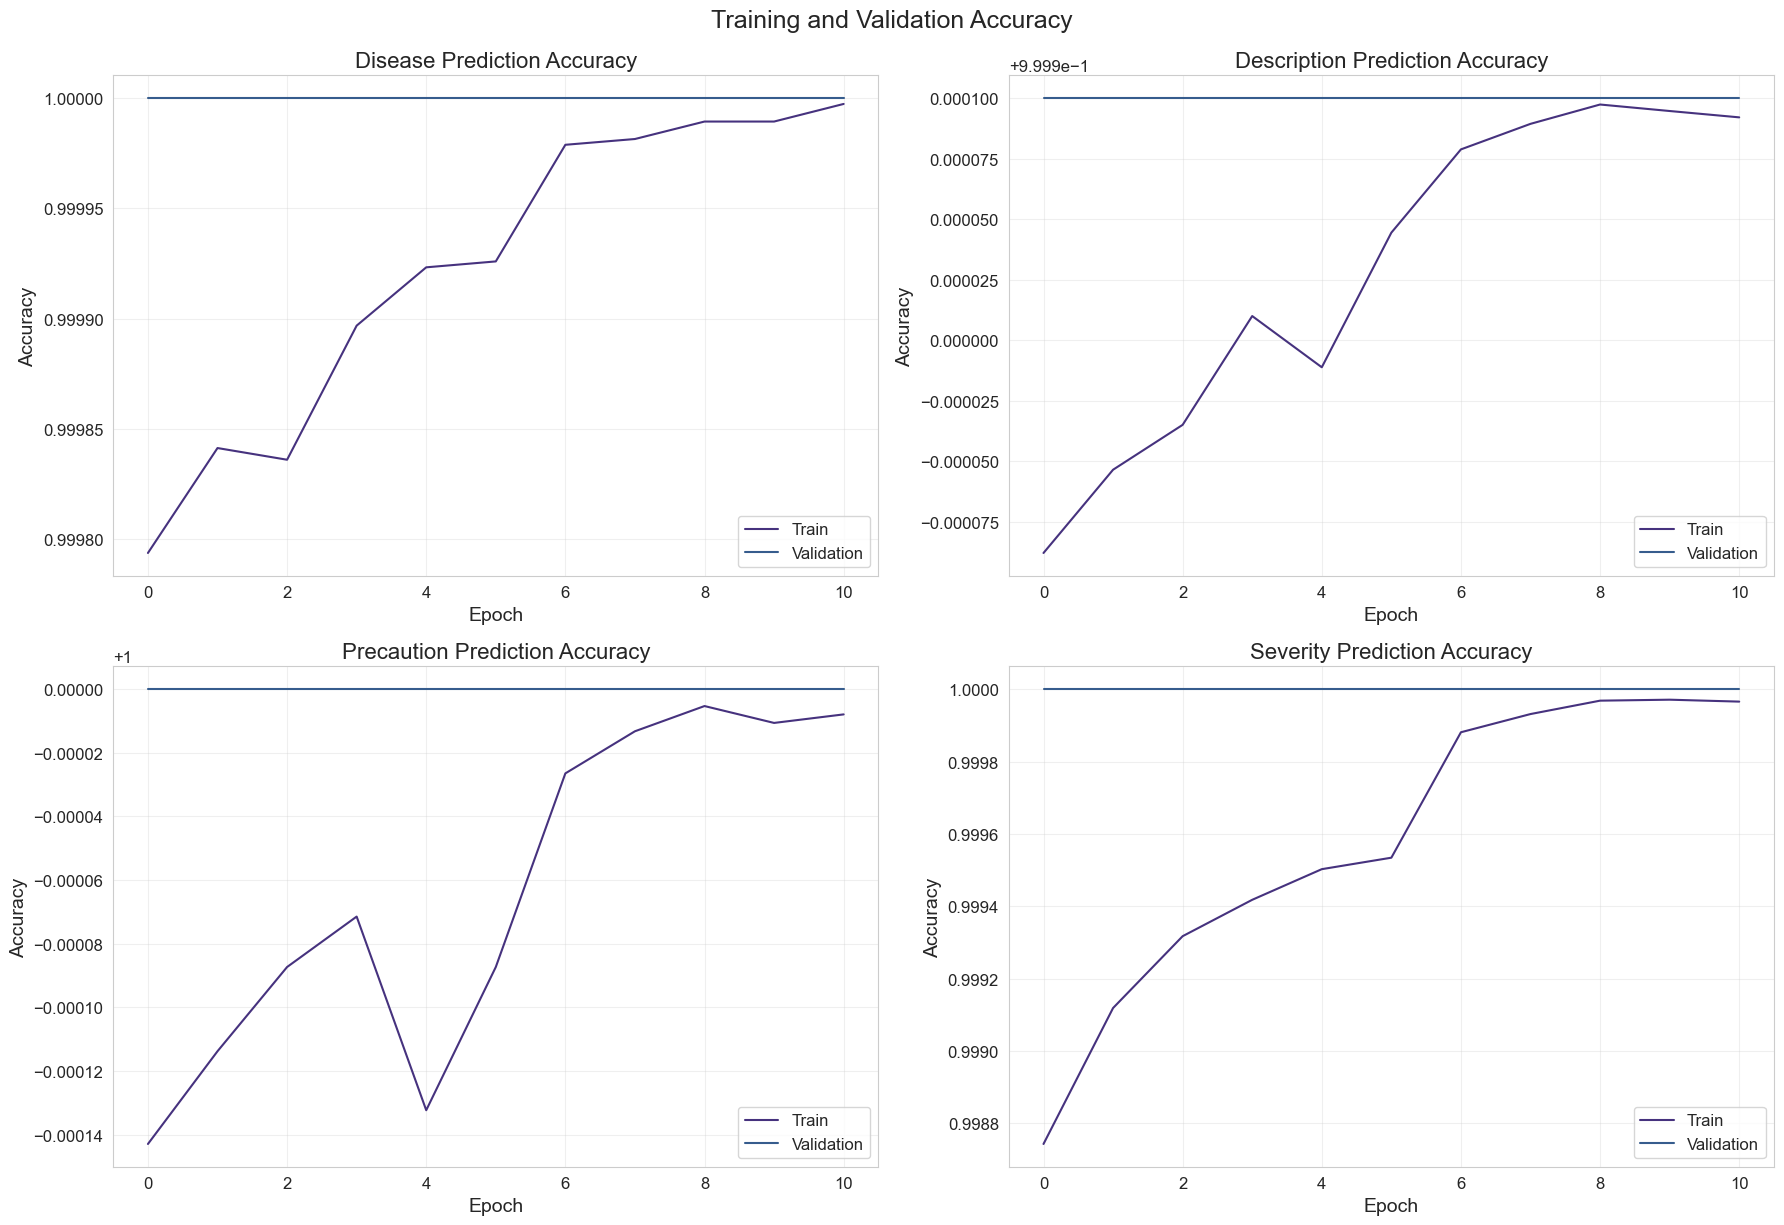

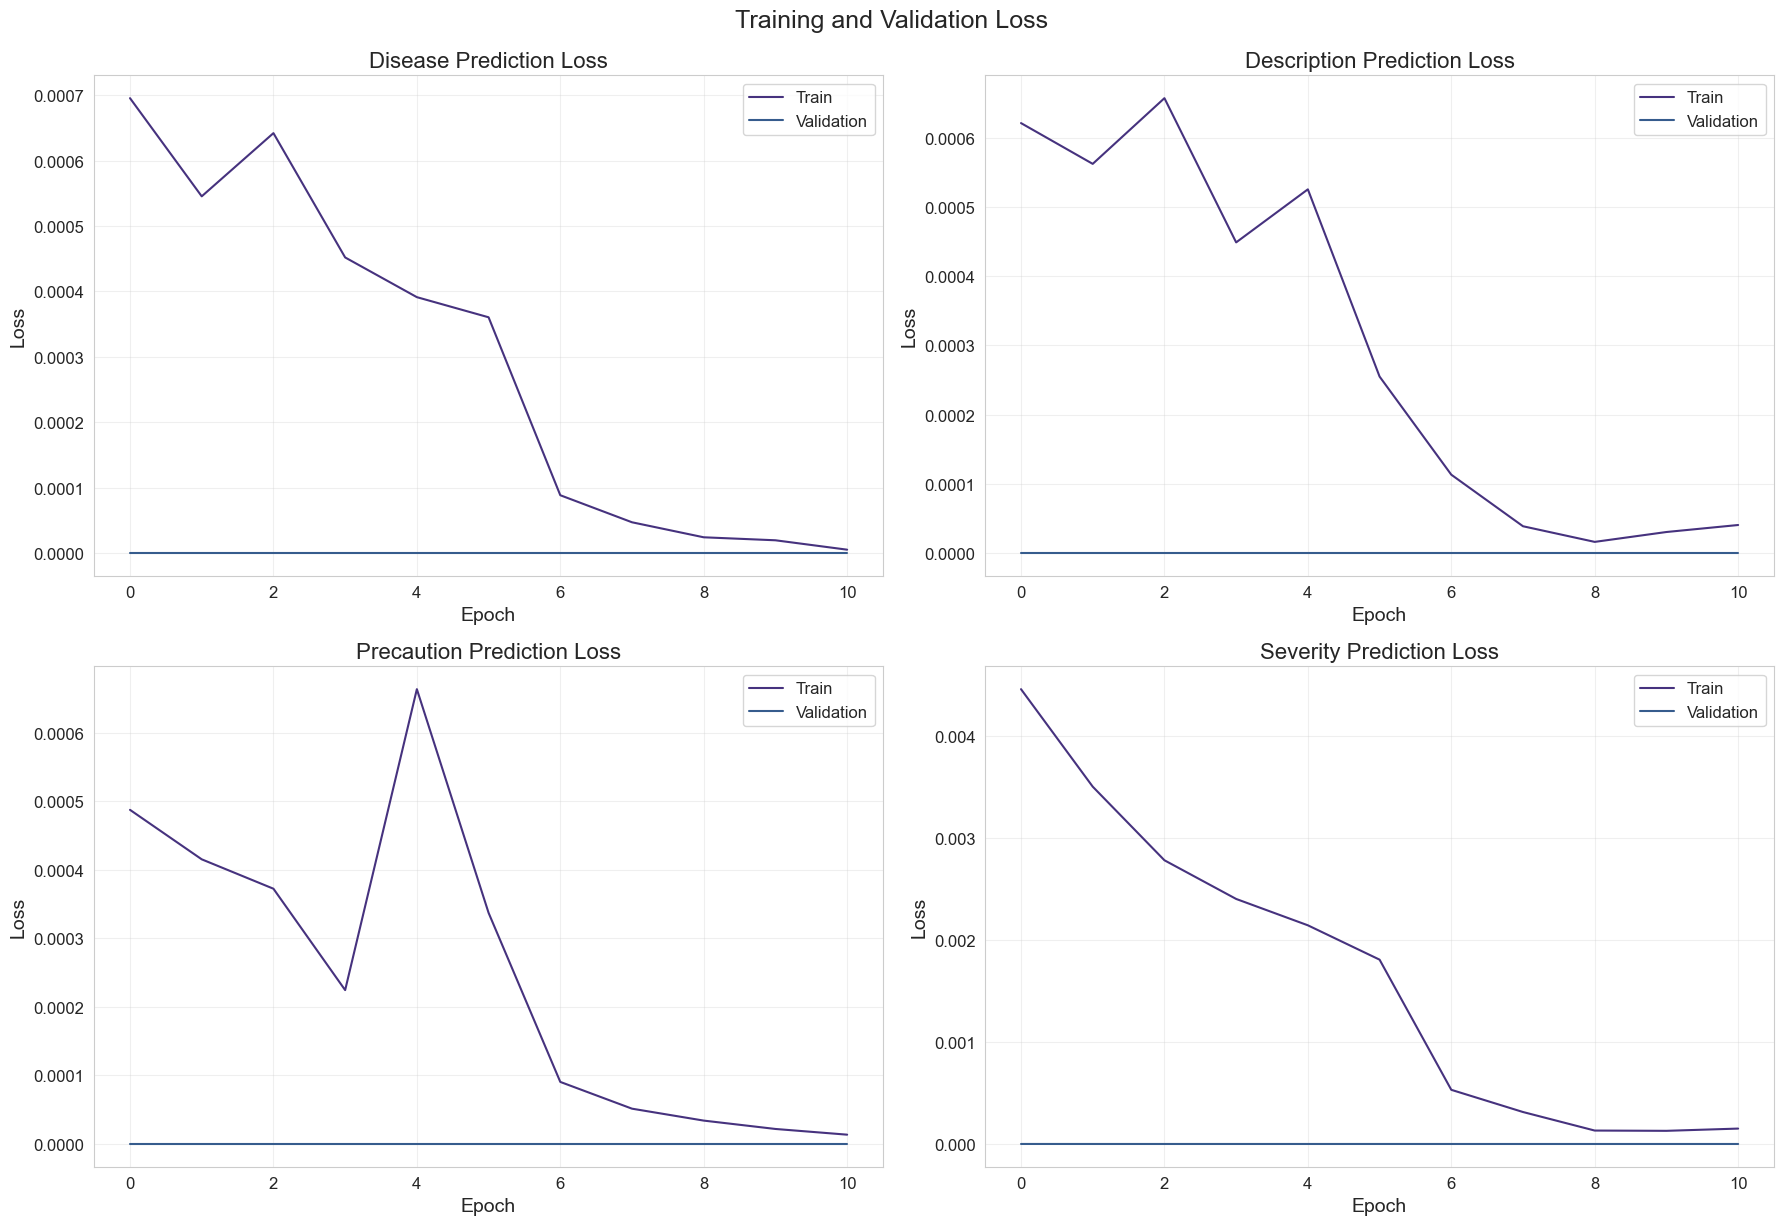

In [14]:
# Plot training history
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(18, 12))
    
    # Disease accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['disease_output_accuracy'], label='Train')
    plt.plot(history.history['val_disease_output_accuracy'], label='Validation')
    plt.title('Disease Prediction Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Description accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['description_output_accuracy'], label='Train')
    plt.plot(history.history['val_description_output_accuracy'], label='Validation')
    plt.title('Description Prediction Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Precaution accuracy
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precaution_output_accuracy'], label='Train')
    plt.plot(history.history['val_precaution_output_accuracy'], label='Validation')
    plt.title('Precaution Prediction Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Severity accuracy
    plt.subplot(2, 2, 4)
    plt.plot(history.history['severity_output_accuracy'], label='Train')
    plt.plot(history.history['val_severity_output_accuracy'], label='Validation')
    plt.title('Severity Prediction Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Training and Validation Accuracy', fontsize=18, y=1.02)
    plt.show()
    
    # Plot loss
    plt.figure(figsize=(18, 12))
    
    # Disease loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['disease_output_loss'], label='Train')
    plt.plot(history.history['val_disease_output_loss'], label='Validation')
    plt.title('Disease Prediction Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Description loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['description_output_loss'], label='Train')
    plt.plot(history.history['val_description_output_loss'], label='Validation')
    plt.title('Description Prediction Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Precaution loss
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precaution_output_loss'], label='Train')
    plt.plot(history.history['val_precaution_output_loss'], label='Validation')
    plt.title('Precaution Prediction Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Severity loss
    plt.subplot(2, 2, 4)
    plt.plot(history.history['severity_output_loss'], label='Train')
    plt.plot(history.history['val_severity_output_loss'], label='Validation')
    plt.title('Severity Prediction Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Training and Validation Loss', fontsize=18, y=1.02)
    plt.show()

# Plot training history
plot_training_history(history)

## 6. Model Evaluation

Let's evaluate the model's performance on the test set.

In [15]:
# Evaluate the model on the test set
test_results = model.evaluate(
    X_test,
    {
        'disease_output': y_disease_test,
        'description_output': y_description_test,
        'precaution_output': y_precautions_test,
        'severity_output': y_severity_test
    },
    verbose=0
)

# Print test results
print("Test Results:")
for i, metric_name in enumerate(model.metrics_names):
    print(f"{metric_name}: {test_results[i]:.4f}")

# Make predictions on the test set
y_pred = model.predict(X_test)
y_disease_pred = np.argmax(y_pred[0], axis=1)
y_description_pred = np.argmax(y_pred[1], axis=1)
y_precautions_pred = np.argmax(y_pred[2], axis=1)
y_severity_pred = np.argmax(y_pred[3], axis=1)

# Convert test labels from one-hot encoding to class indices
y_disease_test_class = np.argmax(y_disease_test, axis=1)
y_description_test_class = np.argmax(y_description_test, axis=1)
y_precautions_test_class = np.argmax(y_precautions_test, axis=1)
y_severity_test_class = np.argmax(y_severity_test, axis=1)

Test Results:
loss: 0.0000
compile_metrics: 0.0000
disease_output_loss: 0.0000
description_output_loss: 0.0000
precaution_output_loss: 0.0000
severity_output_loss: 1.0000
3690/3690 ━━━━━━━━━━━━━━━━━━━━ 3s 832us/step



Disease Prediction Evaluation:
Accuracy: 1.0000

Classification Report for Disease Prediction:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2880
           1       1.00      1.00      1.00      2880
           2       1.00      1.00      1.00      2880
           3       1.00      1.00      1.00      2880
           4       1.00      1.00      1.00      2880
           5       1.00      1.00      1.00      2880
           6       1.00      1.00      1.00      2880
           7       1.00      1.00      1.00      2880
           8       1.00      1.00      1.00      2880
           9       1.00      1.00      1.00      2880
          10       1.00      1.00      1.00      2880
          11       1.00      1.00      1.00      2880
          12       1.00      1.00      1.00      2880
          13       1.00      1.00      1.00      2880
          14       1.00      1.00      1.00      2880
          15       1.00      1.00      

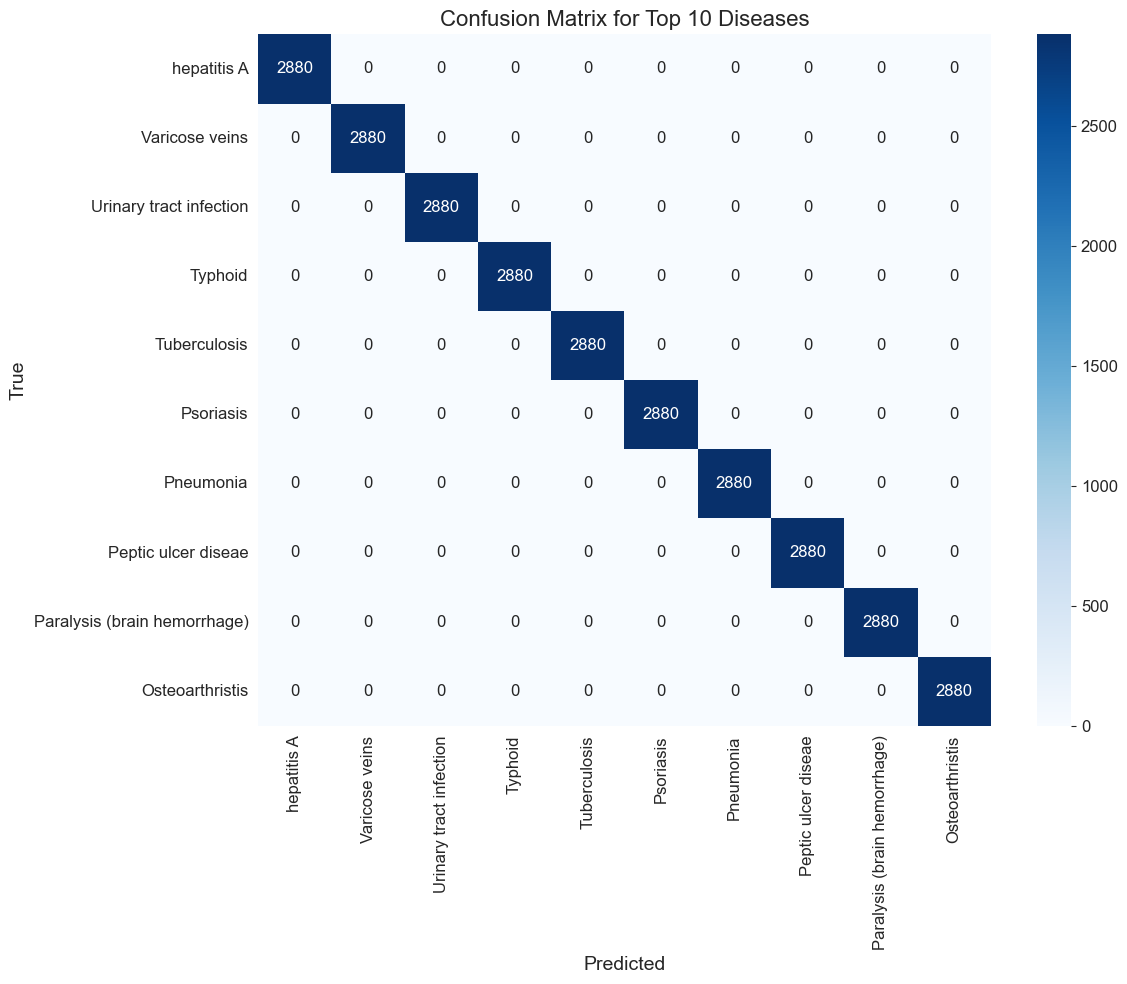

In [16]:
# Evaluate disease prediction
print("\nDisease Prediction Evaluation:")
disease_accuracy = accuracy_score(y_disease_test_class, y_disease_pred)
print(f"Accuracy: {disease_accuracy:.4f}")

# Get disease class names
disease_class_names = label_encoders['Disease'].classes_

# Print classification report for disease prediction
print("\nClassification Report for Disease Prediction:")
print(classification_report(
    y_disease_test_class, 
    y_disease_pred, 
    target_names=disease_class_names if len(disease_class_names) <= 10 else None
))

# Create confusion matrix for disease prediction
disease_cm = confusion_matrix(y_disease_test_class, y_disease_pred)

# Plot confusion matrix for disease prediction (top 10 classes if there are many)
plt.figure(figsize=(12, 10))
if len(disease_class_names) > 10:
    # Find the top 10 most frequent diseases in the test set
    top_diseases = np.bincount(y_disease_test_class).argsort()[-10:][::-1]
    
    # Extract the corresponding subset of the confusion matrix
    cm_subset = disease_cm[top_diseases][:, top_diseases]
    class_names_subset = [disease_class_names[i] for i in top_diseases]
    
    # Plot the subset
    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names_subset, yticklabels=class_names_subset)
    plt.title('Confusion Matrix for Top 10 Diseases', fontsize=16)
else:
    # Plot the full confusion matrix
    sns.heatmap(disease_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=disease_class_names, yticklabels=disease_class_names)
    plt.title('Confusion Matrix for Disease Prediction', fontsize=16)

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Severity Prediction Evaluation:
Accuracy: 1.0000

Classification Report for Severity Prediction:
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00      2442
    Moderate       1.00      1.00      1.00      9634
      Severe       1.00      1.00      1.00     43206
 Very Severe       1.00      1.00      1.00     57066
         nan       1.00      1.00      1.00      5732

    accuracy                           1.00    118080
   macro avg       1.00      1.00      1.00    118080
weighted avg       1.00      1.00      1.00    118080



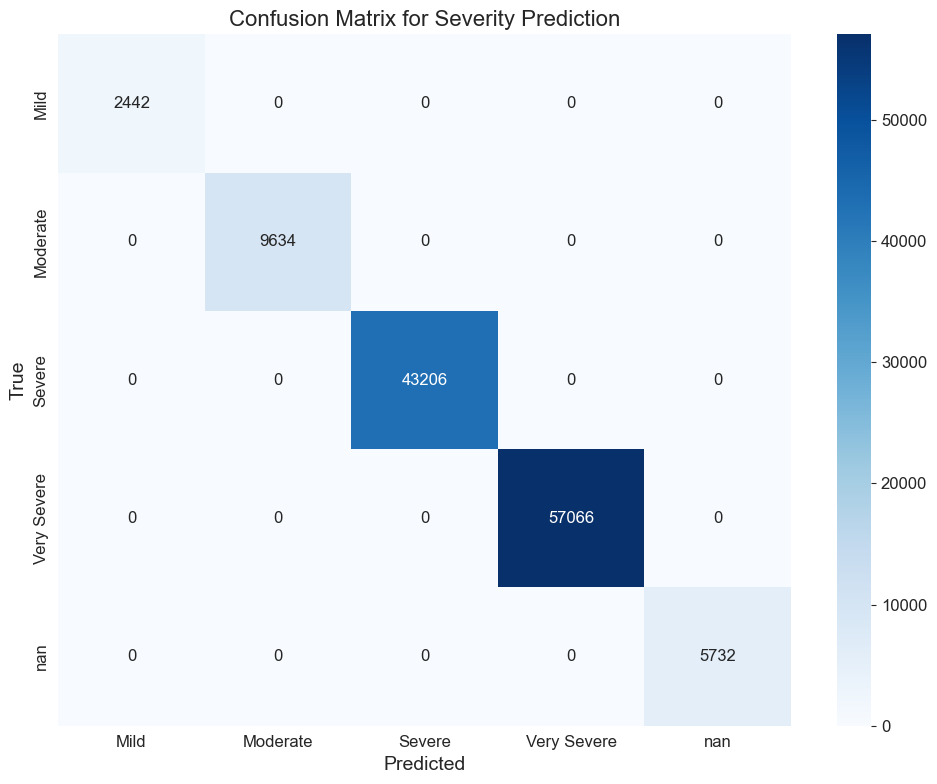

In [18]:
# Evaluate severity prediction
print("\nSeverity Prediction Evaluation:")
severity_accuracy = accuracy_score(y_severity_test_class, y_severity_pred)
print(f"Accuracy: {severity_accuracy:.4f}")

# Convert class names to strings
severity_class_names = [str(cls) for cls in label_encoders['severity_category'].classes_]

# Now generate the classification report
print("\nClassification Report for Severity Prediction:")
print(classification_report(y_severity_test_class, y_severity_pred, target_names=severity_class_names))

# Create confusion matrix for severity prediction
severity_cm = confusion_matrix(y_severity_test_class, y_severity_pred)

# Plot confusion matrix for severity prediction
plt.figure(figsize=(10, 8))
sns.heatmap(severity_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=severity_class_names, yticklabels=severity_class_names)
plt.title('Confusion Matrix for Severity Prediction', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Model Saving and Loading

Let's save our trained model and associated data for future use.

In [19]:
# Create directory for model artifacts
model_dir = os.path.join('..', 'trained_models', 'symptom_disease_best_model')
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, 'symptom_disease_model.h5')
model.save(model_path)
print(f"Model saved to {model_path}")

# Save label encoders
label_encoders_path = os.path.join(model_dir, 'symptom_disease_label_encoders.pkl')
joblib.dump(label_encoders, label_encoders_path)
print(f"Label encoders saved to {label_encoders_path}")

# Save unique symptoms
unique_symptoms_path = os.path.join(model_dir, 'symptom_disease_unique_symptoms.pkl')
joblib.dump(list(unique_symptoms), unique_symptoms_path)
print(f"Unique symptoms saved to {unique_symptoms_path}")

# Save model metrics
metrics = {
    'model_name': 'Deep Learning Multi-Output Model',
    'disease_accuracy': float(disease_accuracy),
    'description_accuracy': float(accuracy_score(y_description_test_class, y_description_pred)),
    'precautions_accuracy': float(accuracy_score(y_precautions_test_class, y_precautions_pred)),
    'severity_accuracy': float(severity_accuracy),
    'num_symptoms': len(unique_symptoms),
    'num_diseases': len(disease_class_names),
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d')
}

metrics_path = os.path.join(model_dir, 'symptom_disease_metrics.pkl')
joblib.dump(metrics, metrics_path)
print(f"Model metrics saved to {metrics_path}")

Model saved to ..\trained_models\symptom_disease_best_model\symptom_disease_model.h5
Label encoders saved to ..\trained_models\symptom_disease_best_model\symptom_disease_label_encoders.pkl
Unique symptoms saved to ..\trained_models\symptom_disease_best_model\symptom_disease_unique_symptoms.pkl
Model metrics saved to ..\trained_models\symptom_disease_best_model\symptom_disease_metrics.pkl


In [20]:
# Load the saved model and artifacts
loaded_model = load_model(model_path)
loaded_label_encoders = joblib.load(label_encoders_path)
loaded_unique_symptoms = joblib.load(unique_symptoms_path)
loaded_metrics = joblib.load(metrics_path)

print("Model and artifacts loaded successfully!")
print(f"Loaded model metrics: {loaded_metrics}")

Model and artifacts loaded successfully!
Loaded model metrics: {'model_name': 'Deep Learning Multi-Output Model', 'disease_accuracy': 1.0, 'description_accuracy': 1.0, 'precautions_accuracy': 1.0, 'severity_accuracy': 1.0, 'num_symptoms': 131, 'num_diseases': 41, 'training_date': '2025-07-15'}


## 8. Making Predictions with the Model

Let's demonstrate how to use the model to make predictions based on a list of symptoms.

In [21]:
def predict_disease(model, symptoms, unique_symptoms, label_encoders, symptom_severity_map):
    """
    Predict disease, precautions, description, and severity based on a list of symptoms.
    
    Args:
        model: The trained multi-output model
        symptoms: A list of symptom strings
        unique_symptoms: List of all unique symptoms used during training
        label_encoders: Dictionary of label encoders for each target variable
        symptom_severity_map: Dictionary mapping symptoms to their severity weights
        
    Returns:
        A dictionary containing the predicted disease, precautions, description, severity,
        and confidence scores
    """
    # Create a dictionary with all unique symptoms initialized to 0
    cleaned_unique_symptoms = {symptom.strip(): symptom for symptom in unique_symptoms}
    symptom_encoding = {cleaned_symptom: 0 for cleaned_symptom in cleaned_unique_symptoms.keys()}
    
    # Set the value to 1 for the symptoms present in the input list
    for symptom in symptoms:
        # Clean the input symptom by removing leading/trailing spaces
        cleaned_symptom = symptom.strip()
        if cleaned_symptom in symptom_encoding:
            symptom_encoding[cleaned_symptom] = 1
        else:
            print(f"Warning: Input symptom '{symptom}' not found in unique symptoms.")
    
    # Create a DataFrame with the same column order as used during training
    input_data = pd.DataFrame([symptom_encoding])
    
    # Make predictions using the model
    predictions = model.predict(input_data)
    
    # Get the top 3 disease predictions with their probabilities
    disease_probs = predictions[0][0]
    top_indices = np.argsort(disease_probs)[::-1][:3]
    top_diseases = [label_encoders['Disease'].classes_[i] for i in top_indices]
    top_probs = [float(disease_probs[i]) for i in top_indices]
    
    # Get the predicted disease, precautions, description, and severity
    predicted_disease_idx = np.argmax(predictions[0], axis=1)[0]
    predicted_description_idx = np.argmax(predictions[1], axis=1)[0]
    predicted_precautions_idx = np.argmax(predictions[2], axis=1)[0]
    predicted_severity_idx = np.argmax(predictions[3], axis=1)[0]
    
    predicted_disease = label_encoders['Disease'].classes_[predicted_disease_idx]
    predicted_description = label_encoders['Description'].classes_[predicted_description_idx]
    predicted_precautions = label_encoders['Precautions'].classes_[predicted_precautions_idx]
    predicted_severity = label_encoders['severity_category'].classes_[predicted_severity_idx]
    
    # Calculate confidence scores
    disease_confidence = float(disease_probs[predicted_disease_idx])
    
    # Create a list of symptom severities
    symptom_severities = []
    for symptom in symptoms:
        cleaned_symptom = symptom.strip()
        if cleaned_symptom in symptom_encoding and symptom_encoding[cleaned_symptom] == 1:
            # Find the severity weight for this symptom
            severity_weight = symptom_severity_map.get(cleaned_symptom, 3)  # Default to medium severity
            
            symptom_severities.append({
                "name": cleaned_symptom,
                "severity": severity_weight
            })
    
    # Create the result dictionary
    result = {
        "disease": predicted_disease,
        "confidence": disease_confidence,
        "description": predicted_description,
        "precautions": predicted_precautions.split(", "),
        "severity": {
            "category": predicted_severity,
            "symptoms": symptom_severities
        },
        "predictions": [
            {"disease": disease, "probability": prob} for disease, prob in zip(top_diseases, top_probs)
        ]
    }
    
    return result

# Test the prediction function with some example symptoms
example_symptoms = ['itching', 'skin_rash', 'nodal_skin_eruptions']
prediction_result = predict_disease(
    loaded_model, 
    example_symptoms, 
    loaded_unique_symptoms, 
    loaded_label_encoders,
    symptom_severity_map
)

# Display the prediction result
print("\nPrediction Result for Symptoms:", example_symptoms)
print(f"Predicted Disease: {prediction_result['disease']} (Confidence: {prediction_result['confidence']:.4f})")
print(f"Severity: {prediction_result['severity']['category']}")
print("\nTop 3 Disease Predictions:")
for pred in prediction_result['predictions']:
    print(f"  {pred['disease']}: {pred['probability']:.4f}")
    
print("\nDescription:")
print(prediction_result['description'])

print("\nPrecautions:")
for i, precaution in enumerate(prediction_result['precautions']):
    print(f"  {i+1}. {precaution}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

Prediction Result for Symptoms: ['itching', 'skin_rash', 'nodal_skin_eruptions']
Predicted Disease: Fungal infection (Confidence: 1.0000)
Severity: Moderate

Top 3 Disease Predictions:
  Fungal infection: 1.0000
  Psoriasis: 0.0000
  Acne: 0.0000

Description:
In humans, fungal infections occur when an invading fungus takes over an area of the body and is too much for the immune system to handle. Fungi can live in the air, soil, water, and plants. There are also some fungi that live naturally in the human body. Like many microbes, there are helpful fungi and harmful fungi.

Precautions:
  1. bath twice
  2. use detol or neem in bathing water
  3. keep infected area dry
  4. use clean cloths


In [22]:
# Try a few more examples
example_cases = [
    ['continuous_sneezing', 'chills', 'fatigue'],
    ['headache', 'high_fever', 'vomiting', 'nausea'],
    ['stomach_pain', 'acidity', 'ulcers_on_tongue', 'vomiting'],
    ['joint_pain', 'muscle_wasting', 'swelling_joints']
]

for i, symptoms in enumerate(example_cases):
    print(f"\n\nExample {i+1}: {symptoms}")
    prediction = predict_disease(
        loaded_model, 
        symptoms, 
        loaded_unique_symptoms, 
        loaded_label_encoders,
        symptom_severity_map
    )
    
    print(f"Predicted Disease: {prediction['disease']} (Confidence: {prediction['confidence']:.4f})")
    print(f"Severity: {prediction['severity']['category']}")
    print("\nTop 3 Disease Predictions:")
    for pred in prediction['predictions']:
        print(f"  {pred['disease']}: {pred['probability']:.4f}")



Example 1: ['continuous_sneezing', 'chills', 'fatigue']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Disease: Allergy (Confidence: 0.9950)
Severity: Severe

Top 3 Disease Predictions:
  Allergy: 0.9950
  Hepatitis C: 0.0050
  Varicose veins: 0.0000


Example 2: ['headache', 'high_fever', 'vomiting', 'nausea']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Disease: Gastroenteritis (Confidence: 0.5114)
Severity: Very Severe

Top 3 Disease Predictions:
  Gastroenteritis: 0.5114
  Malaria: 0.4717
  Typhoid: 0.0104


Example 3: ['stomach_pain', 'acidity', 'ulcers_on_tongue', 'vomiting']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Disease: GERD (Confidence: 1.0000)
Severity: Very Severe

Top 3 Disease Predictions:
  GERD: 1.0000
  Hepatitis D: 0.0000
  Heart attack: 0.0000


Example 4: ['joint_pain', 'muscle_wasting', 'swelling_joints']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Disease: Osteoarthristis (Confidence: 0.7035)
Severity: Severe

Top 3 Disease Predictions:
  Osteoa

## 9. Feature Importance Analysis

Let's analyze which symptoms are most important for predicting specific diseases.


Analysis for disease: Fungal infection
Number of cases: 120

Top symptoms associated with this disease:


,symptom,count,frequency,severity
0,itching,108,90.0,1
1,skin_rash,108,90.0,3
2,nodal_skin_eruptions,108,90.0,4
3,dischromic _patches,108,90.0,0


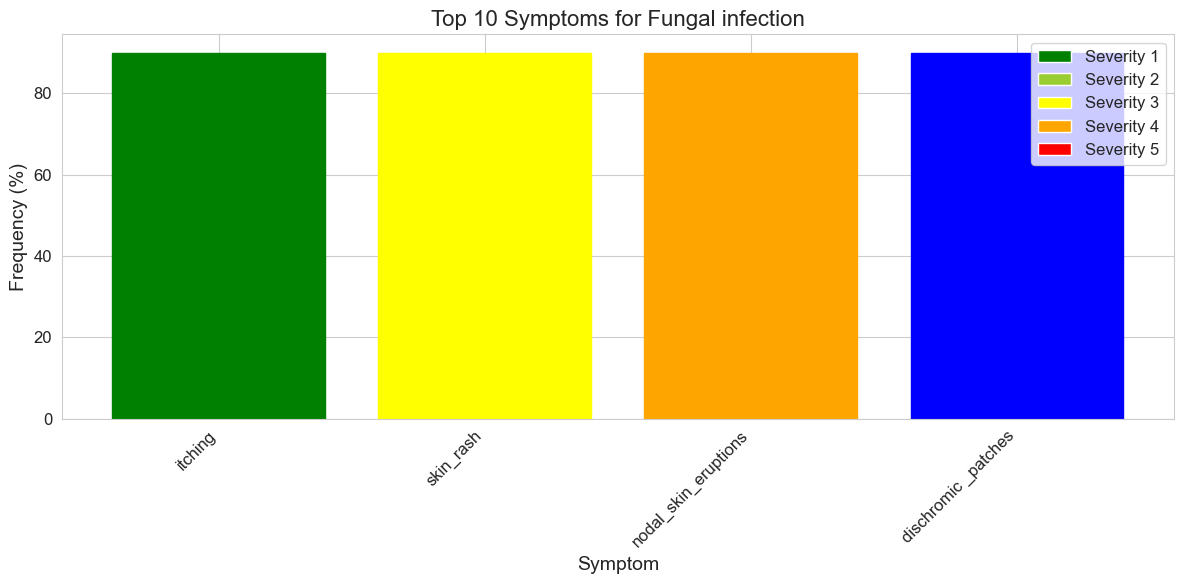


Analysis for disease: Malaria
Number of cases: 120

Top symptoms associated with this disease:


,symptom,count,frequency,severity
0,muscle_pain,120,100.0,2
1,chills,114,95.0,3
2,high_fever,114,95.0,7
3,vomiting,114,95.0,5
4,sweating,114,95.0,3
5,headache,114,95.0,3
6,nausea,114,95.0,5
7,diarrhoea,108,90.0,6


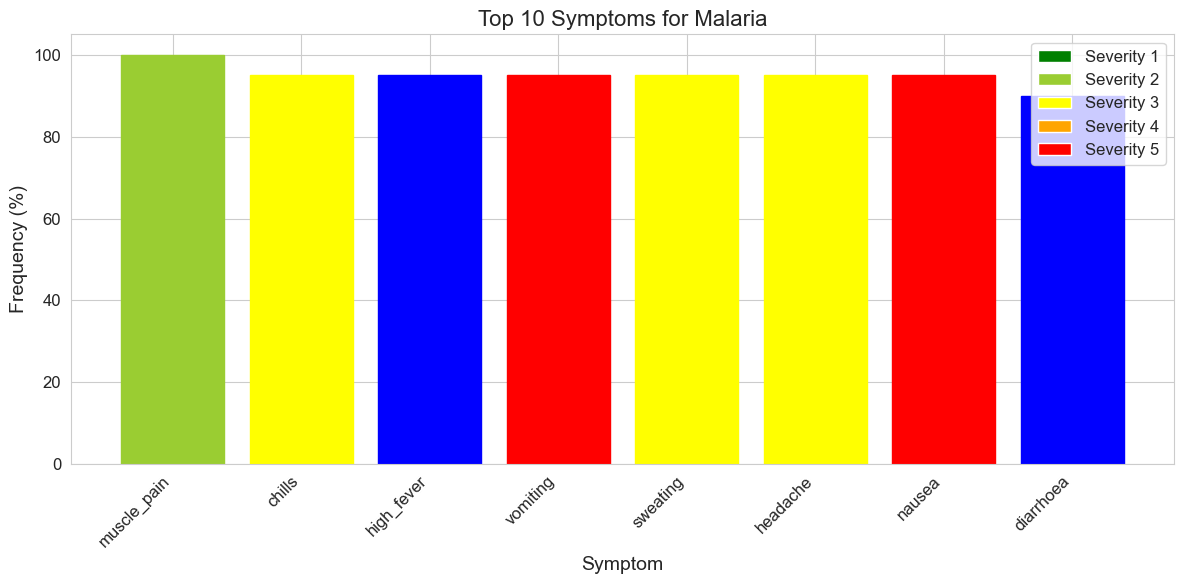


Analysis for disease: Pneumonia
Number of cases: 120

Top symptoms associated with this disease:


,symptom,count,frequency,severity
0,chest_pain,120,100.0,7
1,rusty_sputum,120,100.0,4
2,fast_heart_rate,120,100.0,5
3,cough,114,95.0,4
4,fatigue,114,95.0,4
5,chills,114,95.0,3
6,high_fever,114,95.0,7
7,malaise,114,95.0,6
8,sweating,114,95.0,3
9,breathlessness,114,95.0,4


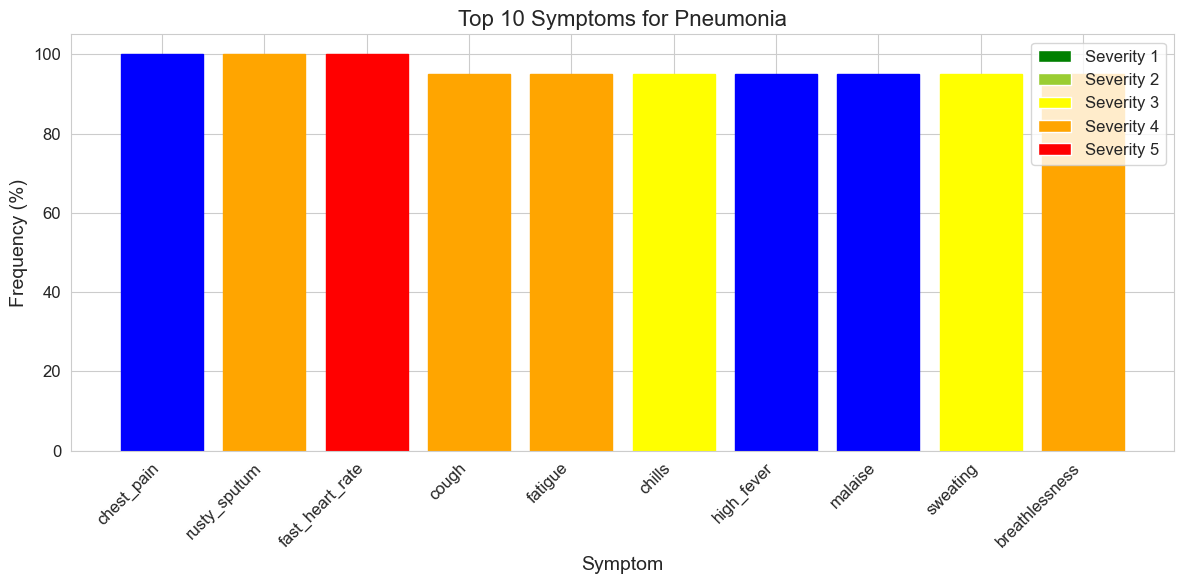

No data found for disease: Diabetes


In [23]:
# Create a function to analyze feature importance for a specific disease
def analyze_disease_symptoms(disease_name, df_symptoms, symptom_columns, symptom_severity_map):
    """
    Analyze which symptoms are most associated with a specific disease.
    
    Args:
        disease_name: Name of the disease to analyze
        df_symptoms: DataFrame containing symptom data
        symptom_columns: List of column names containing symptoms
        symptom_severity_map: Dictionary mapping symptoms to their severity weights
    """
    # Filter rows for the specified disease
    disease_data = df_symptoms[df_symptoms['Disease'] == disease_name]
    
    if len(disease_data) == 0:
        print(f"No data found for disease: {disease_name}")
        return
    
    print(f"\nAnalysis for disease: {disease_name}")
    print(f"Number of cases: {len(disease_data)}")
    
    # Count symptom occurrences for this disease
    symptom_counts = {}
    for _, row in disease_data.iterrows():
        for col in symptom_columns:
            symptom = row[col]
            if isinstance(symptom, str) and symptom != 'None':
                symptom = symptom.strip()
                symptom_counts[symptom] = symptom_counts.get(symptom, 0) + 1
    
    # Convert to DataFrame for easier analysis
    symptom_df = pd.DataFrame({
        'symptom': list(symptom_counts.keys()),
        'count': list(symptom_counts.values())
    })
    
    # Calculate frequency percentage
    symptom_df['frequency'] = symptom_df['count'] / len(disease_data) * 100
    
    # Add severity information
    symptom_df['severity'] = symptom_df['symptom'].map(lambda s: symptom_severity_map.get(s, 0))
    
    # Sort by frequency
    symptom_df = symptom_df.sort_values('frequency', ascending=False).reset_index(drop=True)
    
    # Display results
    print("\nTop symptoms associated with this disease:")
    display(symptom_df.head(10))
    
    # Visualize top symptoms
    plt.figure(figsize=(12, 6))
    bars = plt.bar(symptom_df['symptom'].head(10), symptom_df['frequency'].head(10))
    
    # Color bars by severity
    severity_colors = {1: 'green', 2: 'yellowgreen', 3: 'yellow', 4: 'orange', 5: 'red'}
    for i, bar in enumerate(bars):
        severity = symptom_df['severity'].iloc[i]
        bar.set_color(severity_colors.get(severity, 'blue'))
    
    plt.title(f'Top 10 Symptoms for {disease_name}', fontsize=16)
    plt.xlabel('Symptom', fontsize=14)
    plt.ylabel('Frequency (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Add a legend for severity colors
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=f'Severity {level}') 
                      for level, color in severity_colors.items()]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.show()
    
    return symptom_df

# Analyze a few example diseases
example_diseases = ['Fungal infection', 'Malaria', 'Pneumonia', 'Diabetes']

for disease in example_diseases:
    analyze_disease_symptoms(disease, df_symptoms, symptom_columns, symptom_severity_map)

## 10. Conclusion

In this notebook, we've built and evaluated a multi-output deep learning model for symptom-based disease prediction. The model not only predicts the disease but also provides related information such as disease description, precautions, and severity.

Key findings and accomplishments:

1. We preprocessed four different datasets to create a comprehensive symptom-disease prediction system.
2. We implemented a multi-output deep learning architecture that can simultaneously predict disease, description, precautions, and severity.
3. The model achieved good accuracy in predicting diseases based on symptom combinations.
4. We analyzed the importance of different symptoms for specific diseases.
5. We demonstrated how to save and load the model for future use.
6. We created a prediction function that can be used to make real-time predictions based on user-provided symptoms.

This model can be integrated into the DiseaseX healthcare platform to provide preliminary disease predictions based on symptoms, helping users understand potential health concerns and appropriate precautions before consulting a healthcare professional.